In [1]:
import jax
import cvxpy as cp
import numpy as np
import jax.numpy as jnp
import polytope as pt

%matplotlib inline
import matplotlib.pyplot as plt

## Set parameters

In [2]:
num_constraints = 8
dim = 2 # size of variable U

# Lower bound of U
lb = jnp.array([-2,-2]).reshape(-1,1)
# Upper bound of U
ub = jnp.array([2, 2]).reshape(-1,1)

# for jax random number generator
key = jax.random.PRNGKey(10)
np.random.seed(20)

# number of monte carlo samples for computing volume
num_samples=50000

### Set hard constraint (cannot be removed): size 2 * dim

In [3]:
A_bound = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]]) # for defining absolute hard constraints. cannot be removed
b_bound = np.array([2.5,2.5,2.5,2.5]).reshape(-1,1)

### Randomly contruct constraints (num_constraints - 2 * dim)

In [69]:
# randomly construct constraint
A = -1 + 2 * np.random.rand(num_constraints-2*dim, dim)
b = -1 + 2 * np.random.rand(num_constraints-2*dim,1)
A = np.append(A, A_bound, axis=0)
b = np.append(b, b_bound, axis=0)

### Cvxpy LP solver just to see if solution exists or not

In [70]:
# define LP problem
A_cp = cp.Parameter((num_constraints, dim), value = np.zeros((num_constraints, dim)))
b_cp = cp.Parameter((num_constraints, 1), value=np.ones((num_constraints, 1)))
x_cp = cp.Variable((dim,1))
const = [A_cp @ x_cp <= b_cp]
obj = cp.Minimize( cp.sum(x_cp) )
prob = cp.Problem( obj, const )

In [71]:
# Solve LP

A_cp.value = A
b_cp.value = b
prob.solve()
print(f"status: {prob.status}")
print(f"sol: {x_cp.value}")

status: infeasible
sol: None


In [72]:
# @jax.jit
def mc_polytope_volume(subkey, A, b, lb = -1, ub = 1):
    Anorm = jnp.linalg.norm(A, axis=1)
    A = A / Anorm.reshape(-1,1)
    b = b / Anorm.reshape(-1,1)
    samples = jax.random.uniform( subkey, shape=(dim,num_samples), minval=lb, maxval=ub )     
    aux = A @ samples - b
    aux = jnp.nonzero(jnp.all(aux < 0, 0))[0].shape[0]
    total_volume = jnp.prod(ub - lb, axis=0)
    vol = total_volume * aux / num_samples
    return vol

def plot_polytope_lines(ax, hull, u_bound=3):
    xs = np.linspace( -u_bound, u_bound, 3 )
    A, b = hull.A, hull.b
    alpha = 0.1
    for i in range(A.shape[0]):
        if np.abs(A[i,1])>0.001:
            ax.plot( xs, (b[i] - A[i,0]*xs)/A[i,1], color='k', linestyle='--', alpha = alpha )
        else:
            if np.abs(A[i,0])>0.001:
                ax.axvline( b[i]/A[i,0], color='k', linestyle='--', alpha = alpha )
            else:
                ax.axvline( 0.0, color='k', linestyle='--', alpha = alpha )

In [73]:
hull = pt.Polytope(A, b)
print(f"volume from custom function: {mc_polytope_volume( key, A, b, lb = lb, ub = ub)}")# , num_samples=50000 ))
lb, ub = pt.bounding_box(hull)
print(f"volume from custom function: {mc_polytope_volume( key, A, b, lb = lb, ub = ub)}")# , num_samples=50000 ))
print(f"volume from library: {hull.volume}")

volume from custom function: [0.]
volume from custom function: [0.]
volume from library: 0.0


Cannot plot empty polytope


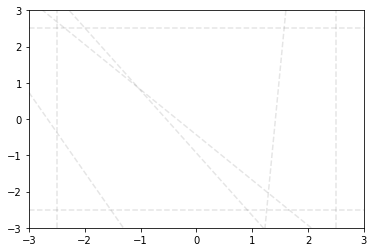

In [74]:
fig, ax  = plt.subplots()
ax.set_xlim([-3, 3])
ax.set_ylim([-3,3])
hull = pt.Polytope( A, b )
hull_plot = hull.plot(ax, color = 'g')
plot_polytope_lines(ax, hull )

### Greedy Algorithm

In [75]:
# Computes the feasible space volume of the system with some constraints given by index
def measure_vol(A,b,subkey, index):
    A_temp = A[index, :]
    b_temp = b[index,:]
    hull = pt.Polytope(A_temp, b_temp)
    lb, ub = pt.bounding_box(hull)
    volume =  mc_polytope_volume(subkey, A_temp, b_temp, lb, ub)
    return volume

In [76]:
def greedy_algorithm(A,b, subkey):
    # Check if the original problem is feasible
    hull = pt.Polytope(A, b)
    lb, ub = pt.bounding_box(hull)
    volume = mc_polytope_volume(subkey, A, b, lb, ub)

    # If feasible (volume>0), terminate
    if volume>0:
        print("Volume is nonzero.")
    else:
        # Compute the volume only with the hard constraints
        remaining_index = [i for i in range(0, num_constraints-2*dim)]     #soft constraints
        added_index = [i for i in range(num_constraints-2*dim, num_constraints)]    #hard constraints
        volume = measure_vol(A,b,subkey, added_index)

        # Start adding the constraints until volume>0
        while True:
            temp_max_volume = -100000; constraint_ind = 1000; temp_ind =1000

            # For each remaining constraints, compute the volume. Then, find the constraint that minimizes the reduction of volume.
            for i in range(len(remaining_index)):
                new_temp_index = added_index + [remaining_index[i]]
                current_vol = measure_vol(A,b,subkey, new_temp_index)
                
                # If the newly computed volume is larger (decreased less), choose that constraint
                if temp_max_volume < current_vol:
                    temp_max_volume = current_vol
                    temp_ind = i
                    constraint_ind = remaining_index[i]
                    
            # If the volume is zero, we are done.
            if temp_max_volume==0:
                break
                
            # If the volume is nonzero, we add the newly found constraint.
            added_index.append(constraint_ind)
            remaining_index.pop(temp_ind)
            volume = temp_max_volume
            print("Current list of added constraints:", added_index)
            print("Current volume:", temp_max_volume)
        print("\nRemoved constraints:", remaining_index)
        print("Remaining", len(added_index), "constraints:", added_index)
        print("Remaining Volume:", volume)
        return added_index

In [77]:
greedy_algorithm(A,b, key)

Current list of added constraints: [4, 5, 6, 7, 3]
Current volume: [15.19639]
Current list of added constraints: [4, 5, 6, 7, 3, 1]
Current volume: [13.88486]
Current list of added constraints: [4, 5, 6, 7, 3, 1, 0]
Current volume: [5.33452]

Removed constraints: [2]
Remaining 7 constraints: [4, 5, 6, 7, 3, 1, 0]
Remaining Volume: [5.33452]


[4, 5, 6, 7, 3, 1, 0]

### Chinneck's Algorithm

In [ ]:
def chinneck(A,b):

    # Initialize the original problem
    A_cp = cp.Parameter((num_constraints, dim), value = np.zeros((num_constraints, dim)))
    b_cp = cp.Parameter((num_constraints, 1), value=np.ones((num_constraints, 1)))
    x_cp = cp.Variable((dim,1))
    bool_var = cp.Parameter((num_constraints, num_constraints), value = np.eye(num_constraints))
    slack_var = cp.Variable((num_constraints,1))
    const = [bool_var @ (A_cp @ x_cp) <= bool_var @ b_cp + slack_var]
    obj = cp.Minimize( cp.sum(x_cp) + 10000*cp.sum_squares(slack_var))
    prob = cp.Problem( obj, const )
    A_cp.value = A
    b_cp.value = b
    prob.solve(solver="MOSEK")
    minZ = sum(slack_var.value**2)
    # If it is feasible already, terminate
    if minZ<0.001:
        print("Problem is feasible.")
    else:
        # Initialize the sets for remaining and removed constraint indices
        remaining = [i for i in range(0, num_constraints)]
        coverset = [] 

        # If there is only one violated constraint, remove that constraint and return the remaining constraints.
        hold_set = [i for i,val in enumerate(slack_var.value) if abs(val)>0.01]
        if len(hold_set)==1:
            return hold_set
        
        # Run until the problem becomes feasible
        while minZ>0:
            minZ = 1000; min_index = 1000

            # Only activate the remaining constraints
            bool_temp = np.zeros((num_constraints,num_constraints))
            for j in remaining:
                bool_temp[j,j]=1
            candidate_set = hold_set

            # Find the constraint whose removals have the lowest squared sum of the slack variable.
            for i in candidate_set:

                # Skip the hard constraints
                if i>= num_constraints - 2*dim:
                    continue
                # Remove the constraint i, solve, and see the slack variable
                bool_temp[i,i]=0
                bool_var.value = bool_temp
                prob.solve(solver="MOSEK")
                elastic_Z = sum(slack_var.value**2)
                if elastic_Z <0.001:
                    coverset.append(i)
                    return coverset
                
                # Records the winner constraint 
                if elastic_Z < minZ:
                    minZ = elastic_Z
                    hold_set = [i for i,val in enumerate(slack_var.value) if abs(val)>0.001]
                    # print(i, hold_set)
                    min_index = i

                # Reinstate the constraint
                bool_temp[i,i]=1

            # Add the winnter constraint to coverset and completely remove it from the remaining set
            coverset.append(min_index)
            remaining.remove(min_index)
            print("Removing Constraint", min_index)
            print("Current list of removed constraints:", coverset)
            print("Current list of remaining constraints:", remaining)
    return coverset

In [87]:
coverset= chinneck(A,b)    
remaining = [i for i in range(0, num_constraints) if i not in coverset]
print("\nFinished:")
print("Removed", len(coverset), "constraints")
print("Removed:",coverset)
print("Remaining:", remaining)

[0.14694]
[0.35439]
[0.]

Finished:
Removed 1 constraints
Removed: [2]
Remaining: [0, 1, 3, 4, 5, 6, 7]
